In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import xarray as xr
import numpy as np
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import cartopy.feature as cfeature
states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none')
import hvplot.xarray
import cartopy.crs as crs

In [3]:
from src.dataloader import *
from src.models import *
from src.trainer import *

In [4]:
DATADRIVE = '/datadrive_ssd/'

In [5]:
ds_train = TiggeMRMSDataset(
    tigge_dir=f'{DATADRIVE}/tigge/32km/',
    tigge_vars=['total_precipitation'],
    mrms_dir=f'{DATADRIVE}/mrms/4km/RadarOnly_QPE_06H/',
    rq_fn=f'{DATADRIVE}/mrms/4km/RadarQuality.nc',
#     const_fn='/datadrive/tigge/32km/constants.nc',
#     const_vars=['orog', 'lsm'],
    data_period=('2018-01', '2018-12'),
    val_days=7,
    split='train'
)

/anaconda/envs/nwp-downscale/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


Loading data


In [6]:
ds_valid = TiggeMRMSDataset(
    tigge_dir=f'{DATADRIVE}/tigge/32km/',
    tigge_vars=['total_precipitation'],
    mrms_dir=f'{DATADRIVE}/mrms/4km/RadarOnly_QPE_06H/',
    rq_fn=f'{DATADRIVE}/mrms/4km/RadarQuality.nc',
#     const_fn='/datadrive/tigge/32km/constants.nc',
#     const_vars=['orog', 'lsm'],
    data_period=('2018-01', '2018-12'),
    val_days=7,
    split='valid',
    mins=ds_train.mins,
    maxs=ds_train.maxs
)

/anaconda/envs/nwp-downscale/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


Loading data


In [7]:
len(ds_train), len(ds_valid)

(19368, 5580)

In [8]:
sampler_train = torch.utils.data.WeightedRandomSampler(ds_train.compute_weights(), len(ds_train))
sampler_valid = torch.utils.data.WeightedRandomSampler(ds_valid.compute_weights(), len(ds_valid))

In [9]:
dl_train = torch.utils.data.DataLoader(ds_train, batch_size=32, sampler=sampler_train)
dl_valid = torch.utils.data.DataLoader(ds_valid, batch_size=32, sampler=sampler_valid)

In [10]:
import torch.nn as nn
import torch

In [11]:
if torch.cuda.is_available():
    device = torch.device("cuda") 
else:
    device = torch.device("cpu")

In [12]:
X, y = next(iter(dl_train))
X.shape, y.shape

(torch.Size([32, 1, 16, 16]), torch.Size([32, 1, 128, 128]))

In [13]:
class DiscriminatorBlock(nn.Module):
    def __init__(self, nf_in, nf_out, stride, batch_norm=True):
        super().__init__()
        layers = []
        layers.append(nn.Conv2d(nf_in, nf_out, kernel_size=3, stride=stride, padding=1))
        if batch_norm:
            layers.append(nn.BatchNorm2d(nf_out))
        layers.append(nn.LeakyReLU(0.2))
        self.block = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.block(x)

In [14]:
class Discriminator(nn.Module):
    def __init__(self, nfs, batch_norm=True, in_size=128):
        super().__init__()
        
        # First layer
        self.first_layer = nn.Sequential(
            nn.Conv2d(1, nfs[0], kernel_size=3, padding=1),
            nn.LeakyReLU(0.2),
            DiscriminatorBlock(nfs[0], nfs[0], stride=2, batch_norm=batch_norm)
        )
        
        # Intermediate layers
        int_layers = []
        for nf_in, nf_out in zip(nfs[:-1], nfs[1:]):
            int_layers.extend([
                DiscriminatorBlock(nf_in, nf_out, stride=1, batch_norm=batch_norm),
                DiscriminatorBlock(nf_out, nf_out, stride=2, batch_norm=batch_norm),
            ])
        self.int_layers = nn.Sequential(*int_layers)
        
        # Final layers
        out_size = (in_size // 2**len(nfs))**2 * nfs[-1]
        print('Size after convolutions', out_size)
        self.final_layers = nn.Sequential(
            nn.Linear(out_size, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        out = self.first_layer(x)
        out = self.int_layers(out)
        out = out.view(out.shape[0], -1)   # Flatten
        out = self.final_layers(out)
        return out

In [15]:
d = Discriminator([16, 16, 32, 32, 64, 64]).to(device)

Size after convolutions 256


In [16]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [17]:
count_parameters(d)

235697

## Pretrain generator

In [18]:
model = Generator(nres=3, nf_in=1, nf=32, relu_out=False).to(device)

In [19]:
criterion = nn.MSELoss()

In [20]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [21]:
trainer = Trainer(model, optimizer, criterion, dl_train, dl_valid)

In [ ]:
trainer.fit(1)

Epoch 1:  45%|████▍     | 270/606 [00:51<01:01,  5.44it/s, train_loss=0.0025] 

## GAN Training

In [75]:
import pdb

In [117]:
class GANTrainer():
    """Implements a Keras-style fit function and tracks train/valid losses"""
    def __init__(self, gen, disc, gen_optimizer, disc_optimizer,  dl_train, dl_valid=None, 
                 valid_every_epochs=1):
        self.gen = gen
        self.disc = disc
        self.gen_optimizer = gen_optimizer
        self.disc_optimizer = disc_optimizer
        self.dl_train = dl_train
        self.dl_valid = dl_valid
        self.valid_every_epochs = valid_every_epochs
        self.criterion = nn.BCELoss()
        
        self.epoch = 0
        self.train_gen_losses = []
        self.train_disc_losses = []
        self.train_epochs = []
#         self.valid_losses = []
#         self.valid_epochs = []
        
    def fit(self, epochs):

        # Epoch loop
        for epoch in range(1, epochs+1):

            prog_bar = tqdm.tqdm(total=len(self.dl_train), desc=f'Epoch {epoch}')
            train_loss, valid_loss = 0, 0

            # Train
            for i, (X, y) in enumerate(self.dl_train):
                X = X.to(device); real = y.to(device)
                bs = X.shape[0]
                
                
                # Train discriminator
                self.disc_optimizer.zero_grad()
                
                fake = self.gen(X)
                cat = torch.cat([real, fake.detach()])
                labels = torch.FloatTensor([1]*bs + [0]*bs).to(device)
                preds = self.disc(cat).squeeze()
                
                disc_loss = self.criterion(preds, labels)
                disc_loss.backward(retain_graph=True)
                self.disc_optimizer.step()
                
                # Compute accuracy
                acc = ((preds > 0.5) == labels).sum().cpu().numpy() / (bs*2)
                
                
                # Train generator
                self.gen_optimizer.zero_grad()
                
                preds = self.disc(fake).squeeze()
                labels = torch.FloatTensor([1]*bs).to(device)
                
                gen_loss = self.criterion(preds, labels)
                gen_loss.backward()
                self.gen_optimizer.step()
                

                prog_bar.update()
#                 train_gen_loss += (loss.item() - train_loss) / (i+1)
                self.train_gen_losses.append(gen_loss.item())
                self.train_disc_losses.append(disc_loss.item())
                prog_bar.set_postfix({
                    'train_gen_loss': gen_loss.item(),
                    'train_disc_loss': disc_loss.item(),
                    'train_acc': acc
                })
#             self.train_gen_losses.append(gen_loss)
            self.train_epochs.append(self.epoch)

#             if (self.epoch-1) % self.valid_every_epochs == 0:
#                 # Valid
#                 for i, (X, y) in enumerate(self.dl_valid):
#                     X = X.to(device); y = y.to(device)
#                     y_hat = self.model(X)
#                     loss = self.criterion(y_hat, y)

#                     valid_loss += (loss.cpu().detach().numpy() - valid_loss) / (i+1)
#                 self.valid_losses.append(valid_loss)
#                 self.valid_epochs.append(self.epoch)

#                 prog_bar.set_postfix({'train_loss': train_loss, 'valid_loss': valid_loss}) 
#                 prog_bar.close()
        
            self.epoch += 1
        
    def plot_losses(self, plot_valid=True):
        plt.plot(self.train_epochs, self.train_losses, label='Train')
        if plot_valid: plt.plot(self.valid_epochs, self.valid_losses, label='Valid')
        plt.legend()

In [174]:
X, y = next(iter(dl_train))
X.shape, y.shape

(torch.Size([32, 1, 16, 16]), torch.Size([32, 1, 128, 128]))

In [175]:
disc = Discriminator([16, 16, 32, 32, 64, 64]).to(device)

Size after convolutions 256


In [176]:
gen = Generator(nres=3, nf_in=1, nf=32, relu_out=False).to(device)

In [177]:
count_parameters(disc), count_parameters(gen)

(235697, 171681)

In [178]:
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)

In [179]:
gen = gen.apply(weights_init)
disc = disc.apply(weights_init)

In [180]:
preds = gen(X.to(device)).detach().cpu().numpy()
preds.shape

(32, 1, 128, 128)

In [181]:
preds[0, 0, 0, 0]

0.009410564

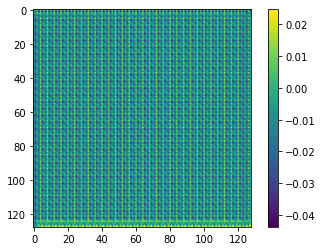

In [182]:
plt.imshow(preds[0, 0])
plt.colorbar()

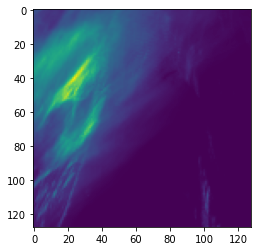

In [200]:
plt.imshow(y[0, 0].detach().cpu().numpy())

### Pretrain?

In [183]:
criterion = nn.MSELoss()

In [184]:
optimizer = torch.optim.Adam(gen.parameters(), lr=1e-4)

In [185]:
trainer = Trainer(gen, optimizer, criterion, dl_train, dl_valid)

In [186]:
trainer.fit(1)

In [187]:
preds = gen(X.to(device)).detach().cpu().numpy()
preds.shape

(32, 1, 128, 128)

In [188]:
preds[0, 0, 0, 0]

0.030197674

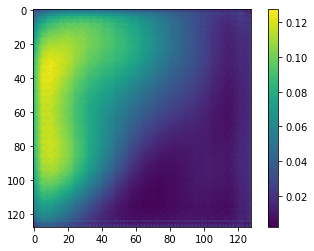

In [189]:
plt.imshow(preds[0, 0])
plt.colorbar()

### GAN Train

In [190]:
disc_optimizer = torch.optim.Adam(disc.parameters(), lr=1e-4)
gen_optimizer = torch.optim.Adam(gen.parameters(), lr=1e-4)

In [191]:
trainer = GANTrainer(gen, disc, gen_optimizer, disc_optimizer, dl_train)

In [192]:
trainer.fit(10)

KeyboardInterrupt: 

In [193]:
preds = gen(X.to(device)).detach().cpu().numpy()
preds.shape

(32, 1, 128, 128)

In [194]:
preds[0, 0, 0, 0]

0.023930077

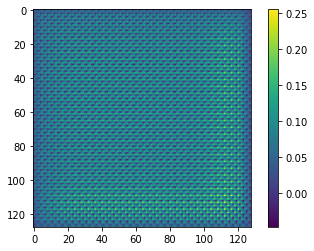

In [195]:
plt.imshow(preds[0, 0])
plt.colorbar()

## WGAN

In [284]:
class Discriminator(nn.Module):
    def __init__(self, nfs, batch_norm=True, in_size=128, sigmoid=True):
        super().__init__()
        self.sigmoid = sigmoid
        
        # First layer
        self.first_layer = nn.Sequential(
            nn.Conv2d(1, nfs[0], kernel_size=3, padding=1),
            nn.LeakyReLU(0.2),
            DiscriminatorBlock(nfs[0], nfs[0], stride=2, batch_norm=batch_norm)
        )
        
        # Intermediate layers
        int_layers = []
        for nf_in, nf_out in zip(nfs[:-1], nfs[1:]):
            int_layers.extend([
                DiscriminatorBlock(nf_in, nf_out, stride=1, batch_norm=batch_norm),
                DiscriminatorBlock(nf_out, nf_out, stride=2, batch_norm=batch_norm),
            ])
        self.int_layers = nn.Sequential(*int_layers)
        
        # Final layers
        out_size = (in_size // 2**len(nfs))**2 * nfs[-1]
        print('Size after convolutions', out_size)
        self.final_layers = nn.Sequential(
            nn.Linear(out_size, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
        )
            
        
    def forward(self, x):
        out = self.first_layer(x)
        out = self.int_layers(out)
        out = out.view(out.shape[0], -1)   # Flatten
        out = self.final_layers(out)
        if self.sigmoid:
            out = torch.functional.sigmoid(out)
        return out

In [285]:
def get_gradient(crit, real, fake, epsilon):
    '''
    Return the gradient of the critic's scores with respect to mixes of real and fake images.
    Parameters:
        crit: the critic model
        real: a batch of real images
        fake: a batch of fake images
        epsilon: a vector of the uniformly random proportions of real/fake per mixed image
    Returns:
        gradient: the gradient of the critic's scores, with respect to the mixed image
    '''
    # Mix the images together
    mixed_images = real * epsilon + fake * (1 - epsilon)

    # Calculate the critic's scores on the mixed images
    mixed_scores = crit(mixed_images)
    
    # Take the gradient of the scores with respect to the images
    gradient = torch.autograd.grad(
        # Note: You need to take the gradient of outputs with respect to inputs.
        # This documentation may be useful, but it should not be necessary:
        # https://pytorch.org/docs/stable/autograd.html#torch.autograd.grad
        #### START CODE HERE ####
        inputs=mixed_images,
        outputs=mixed_scores,
        #### END CODE HERE ####
        # These other parameters have to do with the pytorch autograd engine works
        grad_outputs=torch.ones_like(mixed_scores), 
        create_graph=True,
        retain_graph=True,
    )[0]
    return gradient

In [286]:
def gradient_penalty(gradient):
    '''
    Return the gradient penalty, given a gradient.
    Given a batch of image gradients, you calculate the magnitude of each image's gradient
    and penalize the mean quadratic distance of each magnitude to 1.
    Parameters:
        gradient: the gradient of the critic's scores, with respect to the mixed image
    Returns:
        penalty: the gradient penalty
    '''
    # Flatten the gradients so that each row captures one image
    gradient = gradient.view(len(gradient), -1)

    # Calculate the magnitude of every row
    gradient_norm = gradient.norm(2, dim=1)
    
    # Penalize the mean squared distance of the gradient norms from 1
    #### START CODE HERE ####
    penalty = torch.mean((gradient_norm -1)**2)
    #### END CODE HERE ####
    return penalty

In [310]:
class WGANTrainer():
    """Implements a Keras-style fit function and tracks train/valid losses"""
    def __init__(self, gen, disc, gen_optimizer, disc_optimizer,  dl_train, dl_valid=None, 
                 valid_every_epochs=1, disc_repeats=1, gp_lambda=10):
        self.gen = gen
        self.disc = disc
        self.gen_optimizer = gen_optimizer
        self.disc_optimizer = disc_optimizer
        self.dl_train = dl_train
        self.dl_valid = dl_valid
        self.valid_every_epochs = valid_every_epochs
        self.criterion = nn.BCELoss()
        self.disc_repeats = disc_repeats
        self.gp_lambda = gp_lambda
        
        self.epoch = 0
        self.train_gen_losses = []
        self.train_mse = []
        self.train_disc_losses = []
        self.train_epochs = []
#         self.valid_losses = []
#         self.valid_epochs = []
        
    def fit(self, epochs):

        # Epoch loop
        for epoch in range(1, epochs+1):

            prog_bar = tqdm.tqdm(total=len(self.dl_train), desc=f'Epoch {epoch}')
            train_loss, valid_loss = 0, 0

            # Train
            for i, (X, y) in enumerate(self.dl_train):
                X = X.to(device); real = y.to(device)
                bs = X.shape[0]
                
                mean_disc_loss = 0
                for _ in range(self.disc_repeats):
                    # Train discriminator
                    self.disc_optimizer.zero_grad()

                    fake = self.gen(X)
                    preds_real = self.disc(real)
                    preds_fake = self.disc(fake.detach())
                    
                    epsilon = torch.rand(len(real), 1, 1, 1, device=device, requires_grad=True)
                    gradient = get_gradient(disc, real, fake.detach(), epsilon)
                    gp = gradient_penalty(gradient)
                    
                    disc_loss = -torch.mean(preds_real) + torch.mean(preds_fake) + self.gp_lambda * gp

                    mean_disc_loss += disc_loss.item() / self.disc_repeats
                    disc_loss.backward(retain_graph=True)
                    self.disc_optimizer.step()
                
                
                # Train generator
                self.gen_optimizer.zero_grad()
                
                fake = self.gen(X)
                preds_fake = self.disc(fake)
                
                mse = nn.MSELoss()(fake, real).item()
                
                gen_loss = -torch.mean(preds_fake)
                gen_loss.backward()
                self.gen_optimizer.step()
                

                prog_bar.update()
#                 train_gen_loss += (loss.item() - train_loss) / (i+1)
                self.train_gen_losses.append(gen_loss.item())
                self.train_mse.append(mse)
                self.train_disc_losses.append(mean_disc_loss)
                prog_bar.set_postfix({
                    'train_gen_loss': gen_loss.item(),
                    'train_disc_loss': disc_loss.item(),
                    'mse': mse
                })
#             self.train_gen_losses.append(gen_loss)
            self.train_epochs.append(self.epoch)

#             if (self.epoch-1) % self.valid_every_epochs == 0:
#                 # Valid
#                 for i, (X, y) in enumerate(self.dl_valid):
#                     X = X.to(device); y = y.to(device)
#                     y_hat = self.model(X)
#                     loss = self.criterion(y_hat, y)

#                     valid_loss += (loss.cpu().detach().numpy() - valid_loss) / (i+1)
#                 self.valid_losses.append(valid_loss)
#                 self.valid_epochs.append(self.epoch)

#                 prog_bar.set_postfix({'train_loss': train_loss, 'valid_loss': valid_loss}) 
#                 prog_bar.close()
        
            self.epoch += 1
        
    def plot_losses(self, plot_valid=True):
        plt.plot(self.train_epochs, self.train_losses, label='Train')
        if plot_valid: plt.plot(self.valid_epochs, self.valid_losses, label='Valid')
        plt.legend()

In [311]:
X, y = next(iter(dl_train))
X.shape, y.shape

(torch.Size([32, 1, 16, 16]), torch.Size([32, 1, 128, 128]))

In [312]:
disc = Discriminator([16, 16, 32, 32, 64, 64], sigmoid=False).to(device)

Size after convolutions 256


In [313]:
gen = Generator(nres=3, nf_in=1, nf=32, relu_out=False).to(device)

In [314]:
count_parameters(disc), count_parameters(gen)

(235697, 171681)

In [315]:
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)

In [316]:
gen = gen.apply(weights_init)
disc = disc.apply(weights_init)

In [317]:
betas = (0.5, 0.999)
disc_optimizer = torch.optim.Adam(disc.parameters(), lr=1e-4, betas=betas)
gen_optimizer = torch.optim.Adam(gen.parameters(), lr=1e-4, betas=betas)

In [318]:
trainer = WGANTrainer(gen, disc, gen_optimizer, disc_optimizer, dl_train, disc_repeats=5)

In [325]:
trainer.fit(20)

KeyboardInterrupt: 

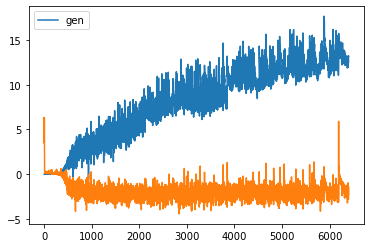

In [326]:
plt.plot(trainer.train_gen_losses, label='gen')
plt.plot(trainer.train_disc_losses)
plt.legend()

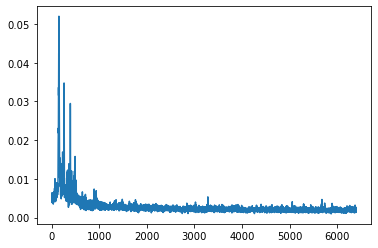

In [327]:
plt.plot(trainer.train_mse)


In [328]:
preds = gen(X.to(device)).detach().cpu().numpy()
preds.shape

(32, 1, 128, 128)

In [329]:
preds[0, 0, 0, 0]

0.021880377

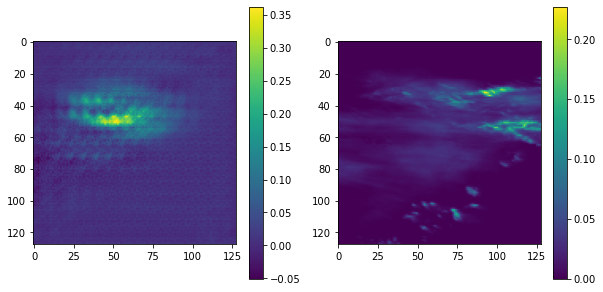

In [330]:
i=9
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
im = ax1.imshow(preds[i, 0])
plt.colorbar(im, ax=ax1)
im = ax2.imshow(y[i, 0].detach().cpu().numpy())
plt.colorbar(im, ax=ax2)